<a href="https://colab.research.google.com/github/priyashah23/dissertation-reddit-controversy/blob/main/Training_BERT_and_RoBERTA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gathering Dataset

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import regex as re
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Read both comment and post data
df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Dissertation/post_with_variance.csv')
comments_df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Dissertation/reddit_comments.csv')

In [ ]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174163 entries, 0 to 174162
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   comment_id           174163 non-null  object 
 1   comment_body         174157 non-null  object 
 2   comment_author       172840 non-null  object 
 3   comment_created      174160 non-null  float64
 4   comment_score        174160 non-null  float64
 5   comment_created_utc  174160 non-null  object 
 6   comment_link_id      174157 non-null  object 
dtypes: float64(2), object(5)
memory usage: 9.3+ MB


In [ ]:
test_df = comments_df.dropna()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

# Tokenizing Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_base_model = AutoModel.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_base_model = bert_base_model.to(device)

In [ ]:
def clean_sentence(sentence):
  # Remove any hyper links
  sentence = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', sentence)
  # Remove white space
  sentence = sentence.replace('\r', '').replace('\n', '')
  return sentence

In [ ]:
post_comments = []
for post_id in tqdm(df["submission_id"]):
  list_of_comments = []
  post_id = 't3_' + post_id

  # Get comments from that post:
  comments = test_df.query('@post_id == comment_link_id')
  for comment in comments['comment_body']:
    # Skip over delete comments
    if comment == "[deleted]":
      continue
    comment = clean_sentence(comment)
    list_of_comments.append(comment)
  post_comments.append(list_of_comments)

df["comments"] = post_comments

  0%|          | 0/971 [00:00<?, ?it/s]

In [ ]:
combined_df = df[["submission_title", "comments", "is_controversial"]]
combined_df.head()

,submission_title,comments,is_controversial
0,Where were you when the GTA 6 trailer dropped ...,"[I was on the couch, I watched it, I moved on ...",1
1,How are Nintendo and Square Enix not suing the...,[Reminder that Pokemon was not the first game ...,1
2,Palworld or Valheim,"[I've played valheim, and it was pretty fun, b...",1
3,"Is the Palworld situation comparable, in a way...",[Other than being able to capture monsters tha...,1
4,"Given the recent unfortunate discourse, I want...","[Is this AI?, Sir, this is a Wendy's, Has anyo...",1


In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
train_ratio = 0.80
test_ratio = 0.20

# train test split
dataset_test_train = Dataset.from_pandas(combined_df).train_test_split(test_size=test_ratio, shuffle = True, seed = 200)

In [ ]:
dataset_test_train.rename_column("is_controversial", "labels"); dataset_test_train

DatasetDict({
    train: Dataset({
        features: ['submission_title', 'comments', 'is_controversial'],
        num_rows: 776
    })
    test: Dataset({
        features: ['submission_title', 'comments', 'is_controversial'],
        num_rows: 195
    })
})

In [ ]:
def generate_embeddings(text, model):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding as the representation for the entire text
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings

In [ ]:
def get_embeddings(dataset, model):
  embeddings = []
  for row in tqdm(dataset):
    submission_title = row["submission_title"]
    comments = row["comments"]
    post_embeddings = generate_embeddings(submission_title, model)
    post_embeddings = post_embeddings.unsqueeze(0)
    comment_embeddings = [generate_embeddings(comment, model) for comment in comments]
    comment_embeddings = torch.stack(comment_embeddings)
    final_embeddings = torch.cat((post_embeddings, comment_embeddings), dim=0)
    # Max pooling
    pooling = torch.max(final_embeddings, dim=0).values
    embeddings.append(pooling)
  return embeddings

In [ ]:
train_embeddings = get_embeddings(dataset_test_train["train"], bert_base_model)

  0%|          | 0/776 [00:00<?, ?it/s]

In [ ]:
test_embeddings = get_embeddings(dataset_test_train["test"], bert_base_model)

  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
y = dataset_test_train["train"]["is_controversial"]
y_train = torch.tensor(y, dtype=torch.float32)

In [ ]:
X_train = torch.stack(train_embeddings)
X_train = X_train.view(len(train_embeddings), -1)

In [ ]:
X_test = torch.stack(test_embeddings)
X_test.size()

torch.Size([195, 1, 768])

In [ ]:
X_test = X_test.view(len(test_embeddings), -1)
y_test = dataset_test_train["test"]["is_controversial"]
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Create Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
train_dataloader = DataLoader(train_dataset,  batch_size=10)

In [ ]:
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=10)

In [ ]:
# Create Neural Network
class ControversialPostsClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(768, 180)
    self.fc2 = nn.Linear(180, 60)
    self.dropout = nn.Dropout(0.5)
    self.out = nn.Linear(60, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.out(x))
    return x

# Create Neural Network

In [ ]:
# torch.manual_seed(41)
classifier_model = ControversialPostsClassifier()
classifier_model.to(device)

# Set criterion and optimiser
criterion = nn.BCELoss() # common for binary classification problems
optimiser = torch.optim.Adam(classifier_model.parameters(), lr=1e-5)

## Create Training Loop

In [ ]:
num_of_epochs = 700

training_loss = []
validation_loss = []

for epoch in tqdm(range(num_of_epochs)):
  classifier_model.train()
  step_loss = []
  for batch in train_dataloader:
    embeddings = batch[0].to(device)
    labels = torch.tensor(batch[1], dtype=torch.float32).unsqueeze(1).to(device)
    optimiser.zero_grad()
    y_pred = classifier_model(embeddings)
    loss = criterion(y_pred, labels)
    # Update
    loss.backward()
    optimiser.step()
    # Calculate loss
    step_loss.append(loss.item())
  # Append the average training loss after each epoch
  training_loss.append(np.array(step_loss).mean())

    # Validation loop
  with torch.no_grad():
    val_step_loss = []
    classifier_model.eval()
  for batch in test_dataloader:
    embeddings = batch[0].to(device)
    labels = torch.tensor(batch[1], dtype=torch.float32).unsqueeze(1).to(device)
    y_pred = classifier_model(embeddings)
    val_loss = criterion(y_pred, labels)
    val_step_loss.append(val_loss.item())

    # Calculate average validation loss
  validation_loss.append(np.array(val_step_loss).mean())


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-34-85da764cfdf7>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.float32).unsqueeze(1).to(device)
<ipython-input-34-85da764cfdf7>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.float32).unsqueeze(1).to(device)


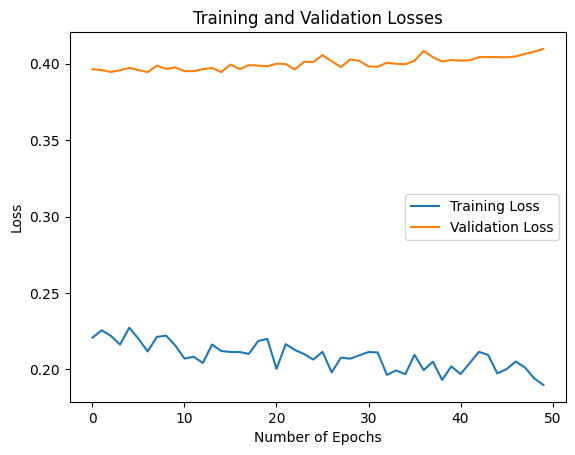

In [ ]:
# Plot both training and validation losses
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
torch.save(classifier_model.state_dict(), 'gdrive/MyDrive/Colab Notebooks/Dissertation/reddit-classifier-controversial-post')

In [ ]:
classifier_model= torch.load('gdrive/MyDrive/Colab Notebooks/Dissertation/reddit-classifier-controversial-post')

In [ ]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

In [ ]:
# Evaluation accuracy after training
# Obtaining Metrics...
y_pred = []
y_true = []

classifier_model.eval()
with torch.no_grad():
  for batch in test_dataloader:
    embeddings = batch[0].to(device)
    labels = torch.tensor(batch[1], dtype=torch.float32).unsqueeze(1)
    output = classifier_model(embeddings) # this gets the predicted value
    predicted_value = output.round().squeeze().cpu().numpy()
    y_true.extend(predicted_value)
    y_pred.extend(labels.cpu().numpy())

# Calculate Metrics
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Recall: ", recall_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred))
print("F1-Score: ", f1_score(y_true, y_pred))

Accuracy:  0.7948717948717948
Recall:  0.8058252427184466
Precision:  0.8058252427184466
F1-Score:  0.8058252427184465


<ipython-input-38-6cc6c5c701c3>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1], dtype=torch.float32).unsqueeze(1)


## Hyperparameter Tuning

In [ ]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
nn_model = NeuralNetClassifier(
    module=ControversialPostsClassifier,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    verbose=True
)

In [ ]:
param_grid = {
    'optimizer__lr':[1e-4, 1e-5, 1e-6],
    'batch_size' : [10, 20, 30, 40, 50],
    'max_epochs': [500, 750, 1000]
}

grid = GridSearchCV(estimator=nn_model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train.unsqueeze(1))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

## K-Fold Cross-Validation

In [ ]:
import sklearn
from sklearn.model_selection import StratifiedKFold, cross_validate

Best: 0.768050 using {'batch_size': 10, 'max_epochs': 1000, 'optimizer__lr': 1e-05}

In [ ]:
dataset = Dataset.from_pandas(combined_df); dataset

Dataset({
    features: ['submission_title', 'comments', 'is_controversial'],
    num_rows: 971
})

In [ ]:
embeddings = get_embeddings(dataset, bert_base_model)

  0%|          | 0/971 [00:00<?, ?it/s]

In [ ]:
X = torch.stack(embeddings)
X = X.view(len(embeddings), -1)

In [ ]:
y = dataset["is_controversial"]
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
nn_model = NeuralNetClassifier(
    module=ControversialPostsClassifier,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    verbose=True,
    lr=1e-05,
    max_epochs=50,
    batch_size=10
)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=43)
scoring = ['f1', 'accuracy', 'precision', 'recall']
result = cross_validate(nn_model, X_combined, y.unsqueeze(1), cv=kfold, scoring=scoring); result

Streaming output truncated to the last 5000 lines.
    263        0.5305       0.5200        0.7298  0.1931
    264        0.5191       0.5200        0.7305  0.1956
    265        0.5218       0.5200        0.7302  0.1947
    266        0.5278       0.5200        0.7304  0.1981
    267        0.5324       0.5200        0.7294  0.2199
    268        0.5245       0.5200        0.7290  0.1999
    269        0.5265       0.5143        0.7287  0.1936
    270        0.5201       0.5200        0.7287  0.1900
    271        0.5165       0.5143        0.7294  0.1976
    272        0.5254       0.5200        0.7295  0.2103
    273        0.5094       0.5200        0.7308  0.1963
    274        0.5222       0.5200        0.7314  0.2006
    275        0.5190       0.5200        0.7321  0.2889
    276        0.5256       0.5200        0.7315  0.2793
    277        0.5143       0.5143        0.7316  0.2643
    278        0.5080       0.5200        0.7329  0.2481
    279        0.5256       0.5200   

{'fit_time': array([159.51213121, 161.7426219 , 159.51931095, 164.7580905 ,
        162.52595186, 167.97006226, 165.90940881, 169.36741757,
        169.22427297, 169.52843308]),
 'score_time': array([0.01343536, 0.01257777, 0.01982379, 0.01348567, 0.02021956,
        0.01555419, 0.01744103, 0.0164845 , 0.01881671, 0.01564097]),
 'test_f1': array([0.68686869, 0.79166667, 0.71428571, 0.82105263, 0.77894737,
        0.7961165 , 0.76086957, 0.76470588, 0.72916667, 0.75      ]),
 'test_accuracy': array([0.68367347, 0.79381443, 0.71134021, 0.82474227, 0.78350515,
        0.78350515, 0.77319588, 0.75257732, 0.73195876, 0.73195876]),
 'test_precision': array([0.68      , 0.80851064, 0.71428571, 0.84782609, 0.80434783,
        0.75925926, 0.81395349, 0.73584906, 0.72916667, 0.69642857]),
 'test_recall': array([0.69387755, 0.7755102 , 0.71428571, 0.79591837, 0.75510204,
        0.83673469, 0.71428571, 0.79591837, 0.72916667, 0.8125    ])}

In [ ]:
import numpy as np

print(f"Accuracy: {np.mean(result['test_accuracy'])}\n" +
      f"Precision: {np.mean(result['test_precision'])}\n" +
      f"f1_score: {np.mean(result['test_f1'])}\n" +
      f"Recall: {np.mean(result['test_accuracy'])}\n")

Accuracy: 0.7570271407532084
Precision: 0.7589627307957428
f1_score: 0.7593679686912436
Recall: 0.7570271407532084



# Classifying Fine-Tuned Model

## Obtain Embeddings for FT model

In [ ]:
# import pre-trained model
model_path = "gdrive/MyDrive/Colab Notebooks/Dissertation/reddit-roberta-ft"
ft_model = AutoModel.from_pretrained(model_path, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of RobertaModel were not initialized from the model checkpoint at gdrive/MyDrive/Colab Notebooks/Dissertation/reddit-roberta-ft and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ft_model = ft_model.to(device)

In [ ]:
train_embeddings = get_embeddings(dataset_test_train["train"], ft_model)
X_train = torch.stack(train_embeddings)
X_train = X_train.view(len(train_embeddings), -1)

  0%|          | 0/776 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
y = dataset_test_train["train"]["is_controversial"]
y_train = torch.tensor(y, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=10)

In [ ]:
class FT_ControversialPostsClassifier(nn.Module):
  def __init__(self, dropout_rate=0.45):
    super().__init__()
    self.fc1 = nn.Linear(768, 180)
    self.fc2 = nn.Linear(180, 60)
    self.dropout = nn.Dropout(dropout_rate)
    self.out = nn.Linear(60, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.out(x))
    return x

In [ ]:
torch.manual_seed(41)
ft_classifier_model = FT_ControversialPostsClassifier()
ft_classifier_model.to(device)

# Set criterion and optimiser
criterion = nn.BCELoss() # common for binary classification problems
optimiser = torch.optim.Adam(ft_classifier_model.parameters(), lr=0.00001)

In [ ]:
num_of_epochs = 700
losses = []

ft_classifier_model.train()
for epoch in tqdm(range(num_of_epochs)):
  for i, (x, y) in enumerate(train_dataloader):
    x, y = x.to(device), y.to(device)
    y_pred = ft_classifier_model(x)
    loss = criterion(y_pred, y.unsqueeze(1))
    # Backwards
    optimiser.zero_grad()
    loss.backward()
    # Update
    optimiser.step()

    losses.append(loss.item())

  0%|          | 0/700 [00:00<?, ?it/s]

Epoch [1/700], Loss: 0.7019
Epoch [2/700], Loss: 0.6931
Epoch [3/700], Loss: 0.6822
Epoch [4/700], Loss: 0.6992
Epoch [5/700], Loss: 0.6898
Epoch [6/700], Loss: 0.6828
Epoch [7/700], Loss: 0.6811
Epoch [8/700], Loss: 0.6966
Epoch [9/700], Loss: 0.6904
Epoch [10/700], Loss: 0.6907
Epoch [11/700], Loss: 0.7033
Epoch [12/700], Loss: 0.7008
Epoch [13/700], Loss: 0.6914
Epoch [14/700], Loss: 0.6805
Epoch [15/700], Loss: 0.6969
Epoch [16/700], Loss: 0.6858
Epoch [17/700], Loss: 0.6848
Epoch [18/700], Loss: 0.6921
Epoch [19/700], Loss: 0.6853
Epoch [20/700], Loss: 0.6910
Epoch [21/700], Loss: 0.6738
Epoch [22/700], Loss: 0.6831
Epoch [23/700], Loss: 0.6967
Epoch [24/700], Loss: 0.6799
Epoch [25/700], Loss: 0.6905
Epoch [26/700], Loss: 0.6792
Epoch [27/700], Loss: 0.6703
Epoch [28/700], Loss: 0.6822
Epoch [29/700], Loss: 0.6718
Epoch [30/700], Loss: 0.6712
Epoch [31/700], Loss: 0.6944
Epoch [32/700], Loss: 0.6823
Epoch [33/700], Loss: 0.6760
Epoch [34/700], Loss: 0.7000
Epoch [35/700], Loss: 0

In [ ]:
import pickle
import matplotlib.pyplot as plt

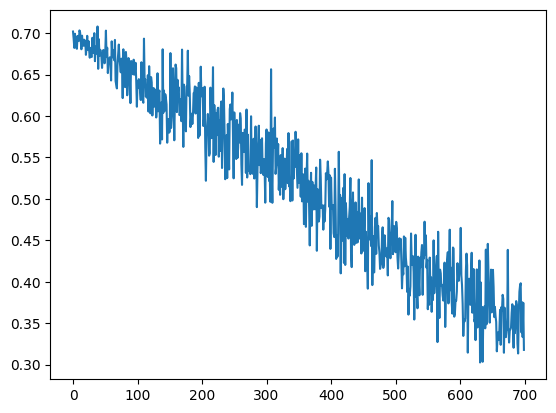

In [ ]:
plt.plot(losses)

In [ ]:
test_embeddings = get_embeddings(dataset_test_train["test"], ft_model)

  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
X_test = torch.stack(test_embeddings)
X_test = X_test.view(len(test_embeddings), -1)
X_test.size()

torch.Size([195, 768])

In [ ]:
y_test = dataset_test_train["test"]["is_controversial"]
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test.size()

torch.Size([195])

In [ ]:
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=10)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
y_pred = []
y_true = []

ft_classifier_model.eval()
with torch.no_grad():
  for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    output = ft_classifier_model(x) # this gets the predicted value
    predicted_value = output.round().squeeze().cpu().numpy()
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted_value)

# Calculate Metrics
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Recall: ", recall_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred))
print("F1-Score: ", f1_score(y_true, y_pred))


Accuracy:  0.8307692307692308
Recall:  0.9029126213592233
Precision:  0.8017241379310345
F1-Score:  0.8493150684931507


In [ ]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Optimisation of the model (Hyper-Parameter Tuning)

In [ ]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
nn_model = NeuralNetClassifier(
    module=FT_ControversialPostsClassifier,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    verbose=False
)

param_grid = {
    'optimizer__lr':[1e-4, 1e-5, 1e-6],
    'batch_size' : [10, 20, 30],
    'max_epochs': [250, 500, 700],
    'module__dropout_rate': [0.25, 0.35, 0.45]
}

# TODO - obtain C and Y
grid = GridSearchCV(estimator=nn_model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train.unsqueeze(1))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.786121 using {'batch_size': 30, 'max_epochs': 250, 'module__dropout_rate': 0.45, 'optimizer__lr': 0.0001}


## K-Fold Cross Validation (Hopefully not taking 2 hours)

In [ ]:
import sklearn
from sklearn.model_selection import StratifiedKFold, cross_validate

In [ ]:
dataset = Dataset.from_pandas(combined_df); dataset
embeddings = get_embeddings(dataset, ft_model)

  0%|          | 0/971 [00:00<?, ?it/s]

In [ ]:
X = torch.stack(embeddings)
X = X.view(len(embeddings), -1)

In [ ]:
y = dataset["is_controversial"]
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
nn_model = NeuralNetClassifier(
    module=FT_ControversialPostsClassifier,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    verbose=True,
    lr=0.0001,
    max_epochs=200,
    batch_size=30
)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=43)
scoring = ['f1', 'accuracy', 'precision', 'recall']
result = cross_validate(nn_model, X, y.unsqueeze(1), cv=kfold, scoring=scoring, n_jobs=-1); result

{'fit_time': array([35.15496898, 34.19560695, 32.47146106, 32.01366544, 33.3389349 ,
        33.84062934, 32.261446  , 32.78818274, 32.08300543, 31.70041895]),
 'score_time': array([0.01655722, 0.01739049, 0.0155232 , 0.01644111, 0.03563714,
        0.01635265, 0.01581383, 0.01784778, 0.01629376, 0.00991821]),
 'test_f1': array([0.7184466 , 0.76      , 0.72727273, 0.83018868, 0.80392157,
        0.75728155, 0.78095238, 0.75229358, 0.73076923, 0.7047619 ]),
 'test_accuracy': array([0.70408163, 0.75257732, 0.69072165, 0.81443299, 0.79381443,
        0.74226804, 0.7628866 , 0.72164948, 0.71134021, 0.68041237]),
 'test_precision': array([0.68518519, 0.74509804, 0.6557377 , 0.77192982, 0.77358491,
        0.72222222, 0.73214286, 0.68333333, 0.67857143, 0.64912281]),
 'test_recall': array([0.75510204, 0.7755102 , 0.81632653, 0.89795918, 0.83673469,
        0.79591837, 0.83673469, 0.83673469, 0.79166667, 0.77083333])}

In [ ]:
import numpy as np

print(f"Accuracy: {np.mean(result['test_accuracy'])}\n" +
      f"Precision: {np.mean(result['test_precision'])}\n" +
      f"f1_score: {np.mean(result['test_f1'])}\n" +
      f"Recall: {np.mean(result['test_accuracy'])}\n")

Accuracy: 0.7374184725436567
Precision: 0.709692830782807
f1_score: 0.7565888224950436
Recall: 0.7374184725436567



# Creating Baseline Model
Here we are applying Hessell and Lee's model for post[text + time] so that we can compare our model's performance to theirs.We have to recreate their model so we can apply our subreddit data.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-large-uncased')
bert_large_model = AutoModel.from_pretrained('google-bert/bert-large-uncased', output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_large_model = bert_large_model.to(device)

In [ ]:
combined_df = df[["submission_title", "created_date", "is_controversial"]]
combined_df.head()

,submission_title,created_date,is_controversial
0,Where were you when the GTA 6 trailer dropped ...,2024-01-25 09:05:29,1
1,How are Nintendo and Square Enix not suing the...,2024-01-23 21:27:52,1
2,Palworld or Valheim,2024-01-24 03:26:02,1
3,"Is the Palworld situation comparable, in a way...",2024-01-27 23:15:13,1
4,"Given the recent unfortunate discourse, I want...",2024-01-24 20:28:27,1


In [ ]:
combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])

for i in range(len(combined_df)):
  combined_df['created_date'][i]=combined_df['created_date'][i].timestamp()

combined_df['created_date'] = combined_df['created_date'].astype('float32')

<ipython-input-12-b98abf94a147>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])
<ipython-input-12-b98abf94a147>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['created_date'][i]=combined_df['created_date'][i].timestamp()
<ipython-input-12-b98abf94a147>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
from datasets import Dataset, DatasetDict
train_ratio = 0.80
test_ratio = 0.20

dataset_test_train = Dataset.from_pandas(combined_df).train_test_split(test_size=test_ratio, shuffle = True, seed = 200)
dataset_test_train.rename_column("is_controversial", "labels"); dataset_test_train

DatasetDict({
    train: Dataset({
        features: ['submission_title', 'created_date', 'is_controversial'],
        num_rows: 776
    })
    test: Dataset({
        features: ['submission_title', 'created_date', 'is_controversial'],
        num_rows: 195
    })
})

In [ ]:
def generate_embeddings(text):
    return tokenizer(text["submission_title"], padding='max_length', truncation=True, return_tensors='pt', max_length=128).to(device)

In [ ]:
tokenized_dataset = dataset_test_train.map(generate_embeddings, batched=True)

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(["submission_title"])
tokenized_dataset = tokenized_dataset.rename_column("is_controversial", "labels"); tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['created_date', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 776
    })
    test: Dataset({
        features: ['created_date', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 195
    })
})

In [ ]:
tokenized_dataset.set_format("torch")

In [ ]:
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=8)

In [ ]:
test_dataloader = DataLoader(tokenized_dataset["test"], shuffle=True, batch_size=8)

In [ ]:
class BertBinaryClassifer(nn.Module):
  def __init__(self, dropout_rate):
    super().__init__()
    self.bert = bert_large_model
    self.dropout = nn.Dropout(dropout_rate)
    self.linear = nn.Linear(1024, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask, time):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = output[1]
    time = time.unsqueeze(1)

    linear_input = self.dropout(pooled_output)
    linear_output = self.linear(linear_input)
    x = self.sigmoid(linear_output)
    return x

In [ ]:
NUMBER_OF_EPOCHS = 20
dropout_rate = 0.2

torch.manual_seed(41)
bert_binary_classifier = BertBinaryClassifer(dropout_rate)
bert_binary_classifier.to(device)

criterion = nn.BCELoss() # common for binary classification problems
optimiser = torch.optim.Adam(bert_binary_classifier.parameters(), lr=0.001)

In [ ]:
losses = []

for epoch in tqdm(range(NUMBER_OF_EPOCHS)):
  for batch in tqdm(train_dataloader):
    batch_count += 1
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    time = batch['created_date'].to(device)
    labels = torch.tensor(batch['labels'], dtype=torch.float32).unsqueeze(1)
    labels = labels.to(device)
    # Backwards
    optimiser.zero_grad()
    output = bert_binary_classifier(input_ids, attention_mask, time)
    loss = criterion(output, labels)
    loss.backward()
    # Update
    optimiser.step()
    losses.append(loss)
    if batch_count % check_loss_every == 0:
      print(f'Epoch: {epoch+1}, Batch: {batch_count}, Loss: {loss.item()}')


In [ ]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

In [ ]:
y_pred = []
y_true = []

bert_binary_classifier.eval()
with torch.no_grad():
  for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    time = batch['created_date'].to(device)
    labels = torch.tensor(batch['labels'], dtype=torch.float32).unsqueeze(1)
    print(labels)
    print(output)

    output = bert_binary_classifier(input_ids, attention_mask, time)
    predicted_value = output.round().cpu().numpy()
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted_value)

print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Recall: ", recall_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred))
print("F1-Score: ", f1_score(y_true, y_pred))

